<h1>Capstone project - Restaurant location - Lecco province, Italy<h1>

In this section of the course I will proceed with an analyses of the best "Comune" in LECCO province, region of Lake of Como, to open a new restaurant. The area choiced for this project is a beautiful location in Italy with a big touristic potentical, so, this will be a very interestanting analysis. Please, join me in my path!

<h2>Project development steps<h2>

* Scratch Data from web and from data tables
* Organize data into a data frame
* Create a map with cities being analyzed
* Retrive information about restaurants using Google API
* Normalize data
* Cluster data and plot it 
* Investigate correlation using heatmap
* Conclusion

<h2>Importing the libraries<h2>

In [10]:
import requests # library to handle requests

import pandas as pd

!pip3 install beautifulsoup4 requests
import requests
from bs4 import BeautifulSoup

!pip install pgeocode
import pgeocode

from geopy.geocoders import Nominatim

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install --upgrade google-api-python-client
from google.oauth2 import service_account
import os

from urllib.request import urlopen, Request
import json

import numpy as np

import pandas as pd
from sklearn import preprocessing

!pip3 install KMeans
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


##  CREDENTIALS

In [2]:
# CREDENTIALS GOOGLE API§
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=(*****)

## Retriving the data - Comunes and Postal Codes

The page "comuneicitta" contains the table in HTML format regarding neighborhoods in province of LECCO and its postalcode. The table is splited into two tables, so, to recover the data it was necessary to run two similar routines in parallel and then merge the resulting dataframe

In [19]:
# set information data page and parse data
url = 'https://www.comuniecitta.it/cap/provincia-lecco-97'

req = requests.get(url)
soup = BeautifulSoup(req.text, "html.parser")

table=soup.find('table', attrs = {'class': 'table table-bordered'})
#print(table.prettify())

table2=soup.findAll('table', attrs = {'class': 'table table-bordered'})[1]
#table2

In [20]:
# Getting data from html

getting_data_table=[]

for tr in table.findAll('td', attrs = {'class':"tvMiddle"}):
    cell = {}
    cell['Data'] = tr.text[:1000]
    getting_data_table.append(cell)
    
getting_data_table2=[]

for tr in table2.find_all('td', attrs = {'class':"tvMiddle"}):
    cell2 = {}
    cell2['Data'] = tr.text[:1000]
    getting_data_table2.append(cell2)

In [21]:
# Convert the table with data into a dataframe

df = pd.DataFrame(getting_data_table)
#df.head(5)

In [22]:
df2 = pd.DataFrame(getting_data_table2)
#df2.head(1)

In [23]:
# Splitting dataframe and creating another dataframe to store cities names

comune = df.iloc[::2]
comune.columns = ['Comune']
comune= comune.reset_index(drop=True)

comune2 = df2.iloc[::2]
comune2.columns = ['Comune']
comune2= comune2.reset_index(drop=True)

In [24]:
# Splitting dataframe and creating another dataframe to store cities names

postalcode = df.iloc[1::2]
postalcode.columns = ['CAP']
postalcode= postalcode.reset_index(drop=True)

postalcode2 = df2.iloc[1::2]
postalcode2.columns = ['CAP']
postalcode2= postalcode2.reset_index(drop=True)

In [25]:
#Resulting dataframe - Merge both dataframes into one

comune_result = comune.append(comune2)
postalcode_result = postalcode.append(postalcode2)

comune_result['CAP'] = postalcode_result['CAP']
comune_result.head()

,Comune,CAP
0,Abbadia Lariana,23821
1,Airuno,23881
2,Annone di Brianza,23841
3,Ballabio,23811
4,Barzago,23890


## Retriving demografic data from Province of Lecco

As Lecco is a very small city (around 50k abitants) and as a very high demografic density I decided to analyze the region of the Province of Lecco, that has a more interesting data distribution and consequently it is a better study case. First I obtained demografic data at istat website, the official italian census. For my study Case I will consider all "Comunes" in Lecco province. Furthermore, I splited Lecco city, the biggest city of province, in neighborhoods. The file with the data had been extracted to CSV format and the steps to transform it in a dataframe can be checked bellow:

In [26]:
# Importing CSV files conteining data regarding neighborhoods of Province of Lecco and creating a 
# general table coteining all the data collected.

frazioni = pd.read_csv (r'/Users/flaviovdiasnt/Documents/Untitled Folder/elenco3.csv', sep=';', encoding='latin-1')
frazioni = frazioni[['Comune', 'Frazione', 'Abitanti']]
Lecco_data=frazioni.merge(comune_result,left_on="Comune",right_on="Comune")
Lecco_data.head()

,Comune,Frazione,Abitanti,CAP
0,Lecco,0,48131,23900
1,Lecco,Centro,6572,23900
2,Lecco,Santo Stefano,5215,23900
3,Lecco,Castello,5208,23900
4,Lecco,Germanedo,4070,23900


After complete data scratching I verified the resulting output data format.

In [27]:
# Remove spaces from the dataframe and verify data type

for column in Lecco_data.columns:
    Lecco_data['Comune'] = Lecco_data['Comune'].apply(lambda x:x.strip() )
    Lecco_data['Frazione'] = Lecco_data['Frazione'].apply(lambda x:x.strip() )
    Lecco_data['CAP'] = Lecco_data['CAP'].apply(lambda x:x.strip() )
    
Lecco_data.dtypes

Comune      object
Frazione    object
Abitanti     int64
CAP         object
dtype: object

It was necessary to cast information regarding CAP (POSTALCODE) from string to integer to make easy the manipulation in next steps.

In [28]:
# Cast CAP from object to integer

Lecco_data['CAP'] = pd.to_numeric(Lecco_data['CAP'],downcast='integer') 
Lecco_data['Abitanti'] = pd.to_numeric(Lecco_data['Abitanti'],downcast='integer') 
Lecco_data.dtypes

Comune      object
Frazione    object
Abitanti     int32
CAP          int16
dtype: object

# Creating code to retrive longitude and latitude data from neighborhood using GOOGLE API

## 1 - Use city name to retrieve geografical info

I used GEOCODE, grom GOOGLE, to retrive longitude and latitude data from neighborhood. The code loops trough the dataframe "Lecco_data" to read neighborhood names and then search for location data into Googles database.
I Converted the column CAP from previous created dataframe into a list and Initialized longitude and latitude list and than I run a loop trought then assgining the values of latitude obtained by geolocator.

In [29]:
pgeocode.Nominatim('it')
geolocator = pgeocode.Nominatim('it')
postal_codes = Lecco_data['CAP'].tolist()
latitudes = []
longitudes = []

for i, postal_code in enumerate(postal_codes):
    # initialize your variable to None
    #print(f'--Getting Postal Code: {postal_code}')
    g = geolocator.query_postal_code(postal_code)
    if not g.empty:
        #print(f'Postal Code {postal_code} has been retrieved. {len(postal_codes) - (i + 1)} codes left')
        latitudes.append(g.latitude)
        longitudes.append(g.longitude)

Append to data frame the lists with latitude and longitude values anf filter NaN values.

In [30]:
Lecco_data['Latitude'] = latitudes
Lecco_data['Longitude'] = longitudes

In [19]:
#Lecco_data= Lecco_data.dropna(how='all')  #Remove all Nan values from dataframe

## 2 - Use neighborhood name to retrieve detailed geografic info

similarly, I use geolocator to findbetter coordinates considering neighborhood location using geolocator. For this instead CAP data I tryed to use neighborhood name to create a loop and obtain geografical data about the places.

In [31]:
geolocator = Nominatim(user_agent='f*****3@*****.com')

locations = Lecco_data['Frazione'].tolist()
latitudes_R = []
longitudes_R = []

for i, location in enumerate(locations):
    #print(f'--Getting Frazione: {location}')
    h = geolocator.geocode(location + ', Lecco, Italia')
    if h != None:
        #print(f'Frazione {location} has been retrieved. {len(locations) - (i + 1)} codes left')
        latitudes_R.append(h.latitude)
        longitudes_R.append(h.longitude)
    else:
        latitudes_R.append(np.NaN)
        longitudes_R.append(np.NaN)

Append the cells with the real coordinates of each neighborhood to the dataframe

In [32]:
Lecco_data['Latitude_R'] = latitudes_R
Lecco_data['Longitude_R'] = longitudes_R

In [33]:
pd.set_option('display.max_rows', 200)
Lecco_data.shape

(100, 8)

In [34]:
Lecco_data.loc[Lecco_data['Comune'].eq('Lecco'), 'Longitude'] = Lecco_data['Longitude_R']
Lecco_data.loc[Lecco_data['Comune'].eq('Lecco'), 'Latitude'] = Lecco_data['Latitude_R']
Definitive_data = Lecco_data.drop(columns=['Latitude_R', 'Longitude_R'])   
Definitive_data.Latitude =Definitive_data.Latitude.round(4)
Definitive_data.Longitude =Definitive_data.Longitude.round(4)
pd.set_option('display.max_rows', 200)
Definitive_data.head(10)

,Comune,Frazione,Abitanti,CAP,Latitude,Longitude
0,Lecco,0,48131,23900,45.8554,9.3896
1,Lecco,Centro,6572,23900,45.6873,9.4237
2,Lecco,Santo Stefano,5215,23900,45.6954,9.4292
3,Lecco,Castello,5208,23900,46.0774,9.3110
4,Lecco,Germanedo,4070,23900,45.8537,9.4172
5,Lecco,Acquate,3800,23900,45.8607,9.4102
6,Lecco,San Giovanni,3601,23900,45.8668,9.4009
7,Lecco,Maggianico,3230,23900,45.8364,9.4159
8,Lecco,Belledo,2776,23900,45.8486,9.4134
9,Lecco,Pescarenico,2865,23900,45.8453,9.3984


## Creating MAPS

In this sections I used GOOGLE API to create map with all locations (Cities of Province of Lecco and Lecco neighborhoods) to be considered in my study case analysis. 

In [35]:
address2 = 'Province of Lecco, Italia'

geolocator2 = Nominatim(user_agent="lecco_explorer")
location2 = geolocator2.geocode(address2)
latitude2 = location2.latitude
longitude2 = location2.longitude
print('The geograpical coordinate of the province of Lecco are {}, {}.'.format(latitude2, longitude2))

The geograpical coordinate of the province of Lecco are 45.8194173, 9.3166621.


Convert values of longitudes and latitudes to numerical values and drop rows that contains NaN values, after print map.

In [36]:
Definitive_data['Latitude_R'] = pd.to_numeric(Definitive_data['Latitude'])
Definitive_data['Longitude_R'] = pd.to_numeric(Definitive_data['Longitude'])
Definitive_data=Definitive_data.dropna(subset=['Longitude'])
Definitive_data= Definitive_data.dropna(subset=['Latitude'])

In [37]:
# create map of Lecco province using latitude and longitude values
map_lecco = folium.Map(location=[latitude2, longitude2], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Definitive_data['Latitude'], Definitive_data['Longitude'], Definitive_data['Frazione'], Definitive_data['Comune']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lecco)   

map_lecco

##  RETRIVING RESTAURANT DATA BASE USING GOOGLE MAPS API

Defining routine to create URL to access Google's database. First step is define the key to access Google's API, the type of place that I am looking for - in this case, restaurant, and the radius around the neighborhood coordinates that I willd o my research. 

In [38]:
Key = '******'
tipo = 'restaurant' # type of place that I am looking for
radius = 1000

In the piece of code bellow I retrieved the latitude and longitude values for each neighborhood of Lecco city and then I add it to a list that I will use to create the URL's.

In [39]:
latitude_search = []
longitude_search = []

for rows in Definitive_data: 
    latitude_search = Definitive_data['Latitude'].tolist()
    longitude_search = Definitive_data['Longitude'].tolist()
    latitude_search.append(latitude_search)
    longitude_search.append(longitude_search)       

In the code bellow I coded a loop that creates a URL list to proceed with requests to Google API.

In [40]:
url = [] #Empty list to store the urls

for i, latitude_search in enumerate(latitude_search):
    #print(f'--Getting Frazione: {location}')
    url_data ='https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={},{}&radius={}&type={}&key={}'.format(
    latitude_search, 
    longitude_search[i], 
    radius,
    tipo,
    Key, 
    )
    url.append(url_data)
del url[-1]

Next I created an empty dataframe to store collected data from google, after I stabilished an routine to read and normalize the JSON files received, convert them into a dataframe ant then append the result of each iteration to the empty dataframe previously created.

In [41]:
locations2 = []
locations3 = pd.DataFrame([])
locations3['Location'] = np.where(Definitive_data['Frazione']=='0', Definitive_data['Comune'], Definitive_data['Frazione'])

for rows in Definitive_data: 

    locations2 = locations3.iloc[:, 0].values.tolist()
    locations2.append(locations2)

Loop to download JSON files from Google, normalize them and transform the data into a dataframe

In [42]:
restaurants = pd.DataFrame([])
response = []

for i, url in enumerate(url):
 
    request=Request(url)
    response = urlopen(request)
    request_data = response.read()
    extracted_data = json.loads(request_data)
    Dataframe_luoghi = pd.json_normalize(extracted_data['results'])
    restaurants = restaurants.append(Dataframe_luoghi)     

Here I create another dataframe to filter the key datas, and I replaced NaN values for 0.

In [43]:
restaurants_essentialdata = restaurants.filter(['Location','business_status', 'name', 'rating', 'user_ratings_total', 'price_level', 'geometry.location.lat', 'geometry.location.lng'], axis=1)
restaurants_essentialdata = restaurants_essentialdata.replace(np.nan, 0)
restaurants_essentialdata = restaurants_essentialdata.reset_index(drop=True)
restaurants_essentialdata.head() # Show the first 5 rows of the dataframe

,business_status,name,rating,user_ratings_total,price_level,geometry.location.lat,geometry.location.lng
0,OPERATIONAL,Curcuma,4.4,731.0,2.0,45.856934,9.385139
1,OPERATIONAL,Santa Lucia,3.8,265.0,2.0,45.855895,9.389873
2,OPERATIONAL,PRINCI'S （VACCANI）,3.5,8.0,0.0,45.854793,9.392463
3,OPERATIONAL,Focacceria Ligure,4.6,148.0,1.0,45.856050,9.389717
4,OPERATIONAL,Hemingway,3.3,440.0,3.0,45.855160,9.389788


In [44]:
restaurants_essentialdata.shape

(845, 7)

# APEENDING GEOGRAFIC AND DEMOGRAFIC DATA TO THE DF RESTAURANTS_ESSENTIALDATA

Now I will do a similar process to add geografic and demografic data to the dataframe retrieved.

In [45]:
url2 = [] #Empty list to store the urls

for i, latitude_search in enumerate(latitude_search):
    #print(f'--Getting Frazione: {location}')
    url_data2 ='https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={},{}&radius={}&type={}&key={}'.format(
    latitude_search, 
    longitude_search[i], 
    radius,
    tipo,
    Key, 
    )
    url2.append(url_data2)
del url2[-1]

And then I created a temporary variable to store the data obtained untill now.

In [46]:
t=locations2 # temporary variable to store the value of location
url_teste=url2 # temporary variable to store the value of url

In [47]:
pop2 = []
pop3 = pd.DataFrame([])
pop3['Population'] = Definitive_data['Abitanti']

for rows in Definitive_data: 

    pop2 = pop3.iloc[:, 0].values.tolist()
    pop2.append(pop2)

In [48]:
comune = pd.DataFrame([])
restaurants2 = pd.DataFrame([])
response2 = []
contador = []
list_city =[]
list_pop=[]

for i, url_teste in enumerate(url_teste):
 
    request2=Request(url_teste)
    response2 = urlopen(request2)
    request_data2 = response2.read()
    extracted_data2 = json.loads(request_data2)
    Dataframe_luoghi2 = pd.json_normalize(extracted_data2['results'])
    row = Dataframe_luoghi2.shape[0]
    
    for x in range(row):
        city = t[i]
        pop = pop2[i]
        list_city.append(city)
        list_pop.append(pop)
        #print(t[x])
    contador.append(row)
    restaurants2.append(Dataframe_luoghi2)      

Converted the list with the name of each neighboorhood where restaurantes are located and the population of each neighborhood to a dataframe.

In [50]:
pdf = pd.DataFrame([])
cdf = pd.DataFrame(list_city) # Dataframe with the name of the neighborhood where rest. are located
pdf['Abitanti'] = pd.DataFrame(list_pop)

For play, I used two different methods to append the dataframes. Assigning it directly and using the concatenate function from pandas

In [51]:
restaurants_essentialdata['Frazione'] = cdf # add location info regarding neighborhood to dataframe

In [52]:
result = pd.concat([restaurants_essentialdata, pdf['Abitanti']], axis=1)# add location info regarding POP to dataframe

In [53]:
result.head()

,business_status,name,rating,user_ratings_total,price_level,geometry.location.lat,geometry.location.lng,Frazione,Abitanti
0,OPERATIONAL,Curcuma,4.4,731.0,2.0,45.856934,9.385139,Lecco,48131
1,OPERATIONAL,Santa Lucia,3.8,265.0,2.0,45.855895,9.389873,Lecco,48131
2,OPERATIONAL,PRINCI'S （VACCANI）,3.5,8.0,0.0,45.854793,9.392463,Lecco,48131
3,OPERATIONAL,Focacceria Ligure,4.6,148.0,1.0,45.856050,9.389717,Lecco,48131
4,OPERATIONAL,Hemingway,3.3,440.0,3.0,45.855160,9.389788,Lecco,48131


## NORMALIZING A DATA FRAME FOR STATISTICAL ANALYSIS

First, I removed the stocatic columns from data frame using the funcion drop.

In [54]:
numerical = result.drop(['business_status', 'name', 'Frazione'], axis=1)
numerical.head()

,rating,user_ratings_total,price_level,geometry.location.lat,geometry.location.lng,Abitanti
0,4.4,731.0,2.0,45.856934,9.385139,48131
1,3.8,265.0,2.0,45.855895,9.389873,48131
2,3.5,8.0,0.0,45.854793,9.392463,48131
3,4.6,148.0,1.0,45.856050,9.389717,48131
4,3.3,440.0,3.0,45.855160,9.389788,48131


Then I normalized the values using sklean preprocessing utilities. 

In [55]:
x = numerical.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
numerical = pd.DataFrame(x_scaled)
numerical.head()

,0,1,2,3,4,5
0,0.88,0.265336,0.666667,0.414245,0.545095,1.0
1,0.76,0.096189,0.666667,0.412090,0.566186,1.0
2,0.70,0.002904,0.000000,0.409801,0.577728,1.0
3,0.92,0.053721,0.333333,0.412411,0.565492,1.0
4,0.66,0.159710,1.000000,0.410562,0.565808,1.0


In [56]:
numerical.shape

(845, 6)

## CLUSTERING RESTAURANTS

Before cluster I eliminated all vlaues 0, that does not bring useful information for the analysis.

In [57]:
result_df = result.loc[(numerical != 0).all(axis=1)]
result_df.shape

(456, 9)

In [58]:
numerical_df= numerical.loc[(numerical != 0).all(axis=1)]
numerical_df.shape

(456, 6)

In [59]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(numerical_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

Then I added cluster label to data table that contains overall information

In [60]:
clustered_data = result_df.filter(['Frazione', 'name','rating', 'user_ratings_total', 'price_level', 'Abitanti'], axis =1)
clustered_data.shape

(456, 6)

'geometry.location.lat', 'geometry.location.lng',

In [61]:
clustered_data.head()

,Frazione,name,rating,user_ratings_total,price_level,Abitanti
0,Lecco,Curcuma,4.4,731.0,2.0,48131
1,Lecco,Santa Lucia,3.8,265.0,2.0,48131
3,Lecco,Focacceria Ligure,4.6,148.0,1.0,48131
4,Lecco,Hemingway,3.3,440.0,3.0,48131
6,Lecco,Trattoria Corte Fiorina,4.3,438.0,2.0,48131


In [62]:
clustered_data.insert(0, 'Cluster Labels', kmeans.labels_)

In [63]:
clustered_data.head()

,Cluster Labels,Frazione,name,rating,user_ratings_total,price_level,Abitanti
0,4,Lecco,Curcuma,4.4,731.0,2.0,48131
1,4,Lecco,Santa Lucia,3.8,265.0,2.0,48131
3,4,Lecco,Focacceria Ligure,4.6,148.0,1.0,48131
4,4,Lecco,Hemingway,3.3,440.0,3.0,48131
6,4,Lecco,Trattoria Corte Fiorina,4.3,438.0,2.0,48131


Finally, I ploted a map of the province indicating the restaurants colored by cluster.

In [64]:
from matplotlib import cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude2, longitude2], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(result['geometry.location.lat'], result['geometry.location.lng'], clustered_data['Frazione'], clustered_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##  CHECKING CLUSTERED DATA

In this section I ploted the table divided by clustered data.

Cluster 0 - Restaurants well evalueted with a average price level 2. We can see that they are in Lecco neighborhoods.

In [73]:
clustered_data.loc[clustered_data['Cluster Labels'] == 0, clustered_data.columns[[0] + list(range(1, clustered_data.shape[1]))]]

,Cluster Labels,Frazione,name,rating,user_ratings_total,price_level,Abitanti
255,0,Casatenovo,Antica Pizzeria,4.6,90.0,1.0,12973
256,0,Casatenovo,Ristorante Sanmauro,3.8,855.0,2.0,12973
257,0,Casatenovo,Tijuana Correzzana,4.0,625.0,1.0,12973
258,0,Casatenovo,Correpizza,4.1,161.0,1.0,12973
263,0,Valmadrera,La Perla,4.0,366.0,2.0,11612
265,0,Valmadrera,Osteria Le Bocce,4.0,213.0,2.0,11612
269,0,Valmadrera,Whisky&Soda,4.5,183.0,2.0,11612
275,0,Valmadrera,RISTORANTE PIZZERIA BAR CUMA,4.1,73.0,2.0,11612
279,0,Mandello del Lario,Ristorante Grigna,4.0,501.0,2.0,10356
280,0,Mandello del Lario,pizzeria pace,4.0,130.0,1.0,10356


Restaurants well evalueted with price level 2. Cities are located in the vinity of Lecco city.

In [74]:
clustered_data.loc[clustered_data['Cluster Labels'] == 1, clustered_data.columns[[0] + list(range(1, clustered_data.shape[1]))]]

,Cluster Labels,Frazione,name,rating,user_ratings_total,price_level,Abitanti
23,1,Centro,Ristorante Pizzeria Natalino,4.1,698.0,2.0,6572
25,1,Centro,Farina Trentatré Merate,4.5,151.0,2.0,6572
26,1,Centro,Café Gourmet,3.6,454.0,2.0,6572
28,1,Centro,PASTICCERIA MILENA,4.1,619.0,2.0,6572
33,1,Santo Stefano,Gelateria Spini,4.2,1129.0,2.0,5215
45,1,Santo Stefano,Farina Trentatré Merate,4.5,151.0,2.0,5215
59,1,Germanedo,Antica Locanda del Ponte,4.1,37.0,2.0,4070
61,1,Germanedo,FIORE cucina in libertà,4.3,515.0,2.0,4070
62,1,Germanedo,Ai Poggi,4.1,563.0,2.0,4070
68,1,Germanedo,Antica Trattoria Americo,3.7,124.0,2.0,4070


Restaurants in Lecco city.

In [75]:
clustered_data.loc[clustered_data['Cluster Labels'] == 2, clustered_data.columns[[0] + list(range(1, clustered_data.shape[1]))]]

,Cluster Labels,Frazione,name,rating,user_ratings_total,price_level,Abitanti
48,2,Castello,Trattoria Da Alberto,4.4,156.0,1.0,5208
52,2,Castello,Pizzeria L'Oasi,4.1,313.0,2.0,5208
53,2,Castello,Goffee Pizzas,4.4,120.0,1.0,5208
55,2,Castello,Urban Fish,4.2,208.0,2.0,5208
56,2,Castello,Crotto del Cech.,4.4,369.0,2.0,5208
315,2,Colico,Il Buon Gusto - Ristorante,4.0,32.0,2.0,7776
316,2,Colico,Pub Front Page,4.0,305.0,2.0,7776
317,2,Colico,Ku'damm,4.2,138.0,2.0,7776
318,2,Colico,Ristorante La Vecchia Osteria,4.1,291.0,2.0,7776
319,2,Colico,Pizzeria Da Nia,4.1,202.0,1.0,7776


Economic restaurants.

In [76]:
clustered_data.loc[clustered_data['Cluster Labels'] == 3, clustered_data.columns[[0] + list(range(1, clustered_data.shape[1]))]]

,Cluster Labels,Frazione,name,rating,user_ratings_total,price_level,Abitanti
21,3,Centro,La Piadineria,4.4,55.0,1.0,6572
35,3,Santo Stefano,La Piadineria,4.4,55.0,1.0,5215
37,3,Santo Stefano,Ristorante Tartaruga,4.0,147.0,1.0,5215
39,3,Santo Stefano,Piadinaif,4.6,69.0,1.0,5215
42,3,Santo Stefano,Carillon Pub,4.3,97.0,1.0,5215
43,3,Santo Stefano,Pizzeria Paradiso Di Tolba Kamal Eldin & C. S....,4.0,30.0,1.0,5215
46,3,Santo Stefano,Pizzeria Alessandria,4.0,64.0,1.0,5215
58,3,Germanedo,Gyrosteria Da Yorgo,4.5,626.0,1.0,4070
63,3,Germanedo,Trattoria Canto Giovannella,4.2,489.0,1.0,4070
64,3,Germanedo,American 2,4.0,57.0,1.0,4070


Restaurants far from Lecco city

In [77]:
clustered_data.loc[clustered_data['Cluster Labels'] == 4, clustered_data.columns[[0] + list(range(1, clustered_data.shape[1]))]]

,Cluster Labels,Frazione,name,rating,user_ratings_total,price_level,Abitanti
0,4,Lecco,Curcuma,4.4,731.0,2.0,48131
1,4,Lecco,Santa Lucia,3.8,265.0,2.0,48131
3,4,Lecco,Focacceria Ligure,4.6,148.0,1.0,48131
4,4,Lecco,Hemingway,3.3,440.0,3.0,48131
6,4,Lecco,Trattoria Corte Fiorina,4.3,438.0,2.0,48131
8,4,Lecco,Cardamomo World Pizza,4.6,215.0,2.0,48131
9,4,Lecco,Aromi,4.2,791.0,2.0,48131
10,4,Lecco,Hambù,4.3,1156.0,2.0,48131
11,4,Lecco,Ristorante Positano,4.4,357.0,3.0,48131
12,4,Lecco,La Bottega Della Pizza 2,4.4,129.0,2.0,48131


The preliminar analysis indicates that there is a correlation between price level and user rating and also by price level and use rating with location.

# INVESTIGATING CORRELATIONS

In this first step I will investigate if there are some correlation between price level and Comune where restaurantes are located and price level and population size of the neighborhood where restaurant is installed. In paralellel I will check for correlations between ratings and price level, and ratings and number of ratings. Finally, with the results of the above mentioned analysis I plan to get an answer on how population size influences on price level and rating of the restaurant and if neighborhood has some influence on those parameters.

To investigate the correlation I used the normalized DF numerical calculated in previous sections of this document. Furthermore, before begin the anlysis I changed the columns titles of the dataframe.

In [78]:
numerical.columns = ['rating', 'user_ratings_total', 'price_level', 'geometry.location.lat', 'geometry.location.lng', 'Abitanti']

In [79]:
numerical.head()

,rating,user_ratings_total,price_level,geometry.location.lat,geometry.location.lng,Abitanti
0,0.88,0.265336,0.666667,0.414245,0.545095,1.0
1,0.76,0.096189,0.666667,0.412090,0.566186,1.0
2,0.70,0.002904,0.000000,0.409801,0.577728,1.0
3,0.92,0.053721,0.333333,0.412411,0.565492,1.0
4,0.66,0.159710,1.000000,0.410562,0.565808,1.0


Here I created a heat map to understand the correlationb etween the parameters. Green means positive correlation, red negative correlation.The stronger the color, the larger the correlation magnitude. From the chart we can see that:
* There is a postive correlation between the total ratings and the price level of the place and population of the neighborhood where restaurant is instaled.
* There is a positive correlation between rating, price level and location of the restaurant.


In [80]:
corr = numerical.corr()

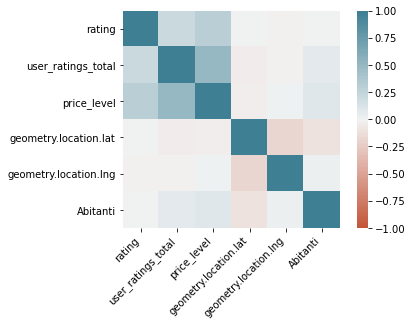

In [82]:
import seaborn as sns
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# CONCLUSION

Considering the clustered data and the heat map I would recommend a new restaurant in the biggest neighborhoods, specially those ones in neighborhoods of Lecco and Valmadrera. This will allow reach better price levels and positive ratings.